In [1]:
'''
Copyright (C) 2019. Huawei Technologies Co., Ltd. All rights reserved.
This program is free software; you can redistribute it and/or modify
it under the terms of the Apache 2.0 License.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
Apache 2.0 License for more details.
'''

import os
import matplotlib.pyplot as plt
import torch

import flsuite
import flsuite.data as data
import flsuite.utils as utils

seed = 0
rounds = 40
local_steps = 200
num_clients = 5
batch_size = 64

save = './data/experiments/comparison/'
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
device = torch.device('cuda')

dataset = data.datasets.RotatedMNIST('./data/datasets')
train_sets = dataset.datasets[:num_clients]
test_set = dataset.datasets[-1]
test_loader = data.build_dataloaders([test_set], batch_size, shuffle=False)[0]

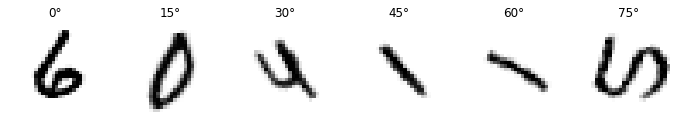

In [2]:
idx = 4
fig, ax = plt.subplots(1, len(dataset.datasets), figsize=(12, 8))
for i, cls in enumerate(dataset.datasets):
    ax[i].imshow(cls[idx][0][0].numpy(), cmap='Greys')
    ax[i].axis('off')
    ax[i].title.set_text(dataset.ENVIRONMENTS[i]+'°')

## Domain Generalization algorithms

### Empirical Risk Minimization (Vapnik 1992)

In [3]:
from flsuite.algs import individual_train

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)
global_loader = data.utils.DataLoaderWrapper(train_loaders)

global_model = flsuite.models.model_loader('RMNIST', 1, seed)[0]
global_model = individual_train(global_model, global_loader, rounds*local_steps, validation_loader=test_loader, \
                                device=device, save=save+'erm', eval_steps=10)

print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))

Test accuracy: 0.946


### Invariant Risk Minimization (Arjovski et al. 2019)

In [ ]:
from flsuite.algs import individual_train
from flsuite.algs.trainers import IRM # non-scalar penalty

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)
global_loader = data.utils.DataLoaderWrapper(train_loaders)

global_model = flsuite.models.model_loader('RMNIST', 1, seed)[0]
global_model = IRM.bind_to(global_model)
global_model = individual_train(global_model, global_loader, rounds*local_steps, validation_loader=test_loader, \
                                device=device, save=save+'irm', eval_steps=10)
print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))

### GroupDRO (Sagawa et al. 2019)

In [4]:
from flsuite.algs import individual_train
from flsuite.algs.trainers import GroupDRO

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)
global_loader = data.utils.DataLoaderWrapper(train_loaders)

global_model = flsuite.models.model_loader('RMNIST', 1, seed)[0]
global_model = GroupDRO.bind_to(global_model)
global_model = individual_train(global_model, global_loader, rounds*local_steps, validation_loader=test_loader, \
                                device=device, save=save+'group_dro', eval_steps=10)

print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))

Test accuracy: 0.944


## Federated Learning Algorithms

### Federated Avg. (McMahan et al. 2017)

In [6]:
from flsuite.algs import fed_avg

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)

models = flsuite.models.model_loader('RMNIST', num_clients, seed)

global_model = fed_avg(models, train_loaders, rounds, local_steps, device=device, save=save+'fed_avg')
print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))

Test accuracy: 0.675


### Agnostic Federated Learning (Mohri et al. 2019)

In [7]:
from flsuite.algs import afl

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)

models = flsuite.models.model_loader('RMNIST', num_clients, seed)

global_model = afl(models, train_loaders, rounds, local_steps, step_size_lambda=0.1, device=device, save=save+'afl')
print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))

Test accuracy: 0.730


###  q-Fair FL (Li et. al 2019)

In [8]:
from flsuite.algs import q_fair

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)

models = flsuite.models.model_loader('RMNIST', num_clients, seed)

global_model = q_fair(models, train_loaders, rounds, local_steps, device=device, save=save+'q_ffl')
print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))

Test accuracy: 0.639


### Proportional Fairness FL (Zhang et al. 2022)

In [9]:
from flsuite.algs import prop_fair

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)

models = flsuite.models.model_loader('RMNIST', num_clients, seed)

global_model = prop_fair(models, train_loaders, rounds, local_steps, base=2, device=device, save=save+'prop_fair')
print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))
# base = 4 - Test accuracy: 0.545
# base = 5 - Test accuracy: 0.515
# base = 6 - Test accuracy: 0.496

Test accuracy: 0.635


### extra: Federated Avg. + Invariant Risk Minimization

In [16]:
from flsuite.algs.trainers import IRM
from flsuite.algs import fed_avg

torch.manual_seed(seed)
train_loaders = data.build_dataloaders(train_sets, batch_size)

models = flsuite.models.model_loader('RMNIST', num_clients, seed)
models = [IRM.bind_to(model) for model in models]
global_model = fed_avg(models, train_loaders, rounds, local_steps, device=device, save=save+'fed_avg_irm')
print('Test accuracy: %.3f' % utils.eval.accuracy(global_model, test_set))

Test accuracy: 0.115
